In [15]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('eth_open.csv')
print(df)

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [17]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_close.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,119.715439,116.157440,117.110756,117.157852,2421720343,117.157852,3.557999,121.718783,127.202195,135.541803,2.622529,15.117100
21,21,2019-01-22,119.664345,114.676682,118.713814,118.747551,2552507405,118.747551,4.987663,121.276579,124.927847,134.455817,2.855369,15.480982
22,22,2019-01-23,119.422798,116.376648,117.462784,117.452606,2556952198,117.452606,3.046150,120.403613,122.543509,132.658995,2.967977,15.139389
23,23,2019-01-24,118.032104,116.006798,117.594955,117.362885,2520843420,117.362885,2.025307,119.537942,121.813580,131.167665,2.736387,15.000088
24,24,2019-01-25,117.802994,115.830154,116.373528,116.378342,2606881898,116.378342,1.972839,118.789242,121.016826,129.359861,2.790005,14.341288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,1661.091309,1583.147827,1608.658325,1608.373169,8909129423,1608.373169,77.943481,1662.544015,1626.081979,1622.118815,32.378460,64.990272
1516,1516,2023-02-25,1608.865112,1567.631714,1594.761108,1594.914917,5657686235,1594.914917,41.233398,1648.698434,1630.009487,1618.670939,38.065500,64.398841
1517,1517,2023-02-26,1645.273438,1590.393066,1640.763672,1640.817139,5727967432,1640.817139,54.880371,1642.759382,1638.998535,1619.105149,35.067535,64.521318
1518,1518,2023-02-27,1662.575684,1615.387939,1634.502441,1634.326416,7239824677,1634.326416,47.187744,1633.002895,1648.106419,1619.985758,23.005899,64.603103


In [18]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

150
(1343, 7, 9) (1343, 1) (150, 7, 9) (150, 1)


In [19]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 9s 11ms/step - loss: 0.0158
Epoch 2/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0045
Epoch 3/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 4/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0046
Epoch 5/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0037
Epoch 6/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0039
Epoch 7/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 8/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 9/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 10/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 11/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 12/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 13/120
40/40 [=====

In [20]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

42/42 [==============================] - 2s 3ms/step
      predict_price  y_train_price  error_price
0        119.780006     106.721954    13.058052
1        113.456215     105.407204     8.049011
2        109.210602     108.900772     0.309830
3        109.452858     107.147682     2.305176
4        109.701347     107.466415     2.234932
...             ...            ...          ...
1338    1352.519409    1329.541382    22.978027
1339    1377.726685    1337.554443    40.172241
1340    1366.126099    1335.646484    30.479614
1341    1367.027344    1328.193726    38.833618
1342    1371.414062    1311.753418    59.660645

[1343 rows x 3 columns]


In [21]:
import pickle
from sklearn.linear_model import ElasticNet

elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [22]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_open.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [23]:
predict_price = model.predict(x_test)
print(predict_price)

5/5 [==============================] - 0s 4ms/step
[[0.26453865]
 [0.25648457]
 [0.25979942]
 [0.2668786 ]
 [0.26458097]
 [0.265095  ]
 [0.26000416]
 [0.25540346]
 [0.25513798]
 [0.25118008]
 [0.24621147]
 [0.2473198 ]
 [0.24459067]
 [0.25248465]
 [0.24772   ]
 [0.2510228 ]
 [0.25611967]
 [0.25502238]
 [0.25064874]
 [0.24843815]
 [0.249138  ]
 [0.25335827]
 [0.26123458]
 [0.26200086]
 [0.28156176]
 [0.3061941 ]
 [0.30576387]
 [0.309373  ]
 [0.32585925]
 [0.32661653]
 [0.3252452 ]
 [0.32441333]
 [0.31412652]
 [0.31123948]
 [0.32763422]
 [0.33241636]
 [0.3214693 ]
 [0.31686258]
 [0.27632117]
 [0.22583546]
 [0.2415719 ]
 [0.248758  ]
 [0.24866186]
 [0.24480747]
 [0.25003418]
 [0.25120002]
 [0.24365388]
 [0.23776674]
 [0.23971541]
 [0.24210505]
 [0.23208779]
 [0.22042626]
 [0.22170219]
 [0.2317102 ]
 [0.23863041]
 [0.23698057]
 [0.2383139 ]
 [0.23455164]
 [0.22762053]
 [0.23265412]
 [0.24658711]
 [0.24815425]
 [0.24901934]
 [0.24413891]
 [0.24687392]
 [0.2477547 ]
 [0.24725315]
 [0.2411324

In [24]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[1345.4164]
 [1307.5183]
 [1323.1161]
 [1356.427 ]
 [1345.6155]
 [1348.0342]
 [1324.0796]
 [1302.4312]
 [1301.182 ]
 [1282.5583]
 [1259.1788]
 [1264.3939]
 [1251.5521]
 [1288.6969]
 [1266.2771]
 [1281.8182]
 [1305.8013]
 [1300.638 ]
 [1280.058 ]
 [1269.6562]
 [1272.9493]
 [1292.8076]
 [1329.8691]
 [1333.475 ]
 [1425.5177]
 [1541.424 ]
 [1539.3995]
 [1556.3821]
 [1633.9574]
 [1637.5206]
 [1631.068 ]
 [1627.1536]
 [1578.7495]
 [1565.1648]
 [1642.3093]
 [1664.8115]
 [1613.3007]
 [1591.624 ]
 [1400.8584]
 [1163.3004]
 [1237.3475]
 [1271.1613]
 [1270.7089]
 [1252.5721]
 [1277.1663]
 [1282.6522]
 [1247.144 ]
 [1219.4425]
 [1228.6117]
 [1239.8562]
 [1192.7205]
 [1137.8477]
 [1143.8514]
 [1190.9437]
 [1223.5065]
 [1215.7432]
 [1222.0171]
 [1204.314 ]
 [1171.7   ]
 [1195.3854]
 [1260.9463]
 [1268.3204]
 [1272.391 ]
 [1249.4263]
 [1262.2959]
 [1266.4403]
 [1264.0803]
 [1235.2798]
 [1260.1195]
 [1267.2479]
 [1262.5541]
 [1259.3846]
 [1254.326 ]
 [1293.795 ]
 [1308.3359]
 [1267.1608]
 [1184.7919]

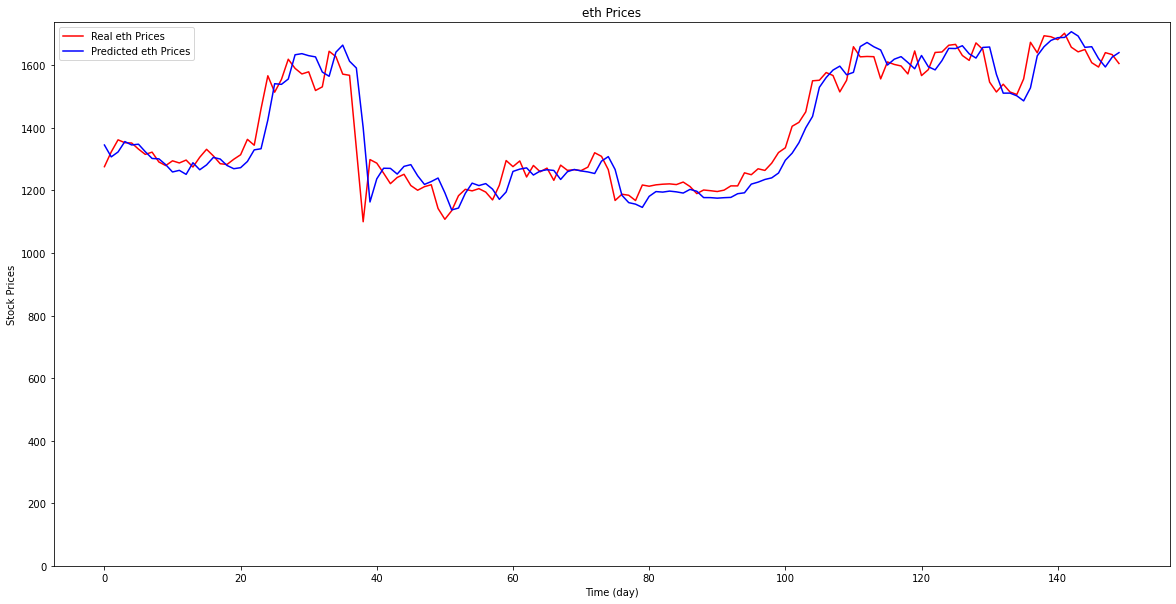

In [25]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real eth Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted eth Prices")
plt.title(f"eth Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [26]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 40.73
MAPE: 2.96%
MSE: 3385.38
RMSE: 58.18
R2: 0.89


In [27]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [28]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))